In [1]:
import os, sys, time

import requests
import shutil

# https://gitlab.com/dlr-ve-esy/esy-osmfilter/-/tree/master/
from esy.osmfilter import  osm_colors          as CC
from esy.osmfilter import run_filter, Node,Way,Relation 
from esy.osmfilter import export_geojson
from contextlib import contextmanager

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import geoplot
import matplotlib.pyplot as plt
# import logging
# logging.basicConfig()
# logger=logging.getLogger(__name__)
# logger.setLevel(logging.INFO)
# logger.setLevel(logging.WARNING)


In [2]:
geofabrik_regions = ["algeria","angola","benin","botswana","burkina_faso","burundi","cameroon","canary_islands","cape_verde","central_african_republic","chad","comores","congo_brazzaville","congo_democratic_republic","djibouti","egypt","equatorial_guinea","eritrea","ethiopia","gabon","ghana","guinea_bissau","guinea","ivory_coast","kenya","lesotho","liberia","libya","madagascar","malawi","mali","mauritania","mauritius","morocco","mozambique","namibia","niger","nigeria","rwanda","saint_helena_ascension_and_tristan_da_cunha","sao_tome_and_principe","senegal_and_gambia","seychelles","sierra_leone","somalia","south_africa_and_lesotho","south_africa","south_sudan","sudan","swaziland","tanzania","togo","tunisia","uganda","zambia","zimbabwe"]

In [11]:
country_name = 'africa' # TODO: Create dictionary with country_code : country_name pairs
country_code = 'AFRICA'
update = False # prevents re-download and filteration of file
element_file_exists = False

# json file for the Data dictionary 
# json file for the Elements dictionary is automatically written to 'data/osm/Elements'+filename)
JSON_outputfile = os.path.join(os.getcwd(),'data','osm',country_name+'_substations.json')

if os.path.exists(JSON_outputfile):
    element_file_exists = True

geofabrik_filename=f'{country_name}-latest.osm.pbf' # Filename for geofabrik 
geofabrik_url = f'https://download.geofabrik.de/africa/{geofabrik_filename}' # https://download.geofabrik.de/africa/nigeria-latest.osm.pbf

PBF_inputfile = os.path.join(os.getcwd(),"data","osm","pbf",geofabrik_filename) # Input filepath

if not os.path.exists(PBF_inputfile) or update or element_file_exists is False:
    print(f"{geofabrik_filename} does not exist, downloading to {PBF_inputfile}")
    os.makedirs(os.path.dirname(PBF_inputfile), exist_ok=True) # create data/osm directory
    with requests.get(geofabrik_url, stream=True) as r:
        with open(PBF_inputfile, 'wb') as f:
            shutil.copyfileobj(r.raw, f)





In [12]:
print(PBF_inputfile, JSON_outputfile)

/home/matin/pypsa-africa/data_exploration/data/osm/pbf/africa-latest.osm.pbf /home/matin/pypsa-africa/data_exploration/data/osm/africa_substations.json


In [20]:
#see https://dlr-ve-esy.gitlab.io/esy-osmfilter/filter.html for filter structures

prefilter = {Node: {"power":["substation"]}, Way: {"power":["substation"]}, Relation: {"power":["substation"]}}
blackfilter = [("pipeline","substation"),] # HACKY: due to esy.osmfilter
whitefilter =[[("power","substation"),],]
    
elementname=f'{country_code}_substations'

if update is False or element_file_exists is False:
    create_elements = False # Do not create elements again
    new_prefilter_data = False #Do not pre-filter data again
    print("Loading Pickle")
else :
    create_elements = True # Do not create elements again
    new_prefilter_data = True #Do not pre-filter data again
    print("Creating  New Elements")

[Data,Elements]=run_filter(elementname,PBF_inputfile, JSON_outputfile,prefilter,whitefilter,blackfilter, NewPreFilterData=new_prefilter_data, CreateElements=create_elements, LoadElements=True,verbose=True,multiprocess=True)

# export the elements to a geojson-file
# export_geojson(Elements[elementname]['Way'],Data,filename='test.geojson',jsontype='Line')
# convert extract node elements
# export_geojson(Elements[elementname]['Node'],Data,filename='test.geojson',jsontype='Point')

Loading Pickle


In [51]:
df_way = pd.json_normalize(Elements[elementname]["Way"].values())
df_way.dropna(subset=['tags.voltage'], inplace = True) # Drop any substations with Voltage = N/A
# na_values_voltage = df_way.isna().sum()
df_way.dropna(thresh=len(df_way)*0.25, axis=1, how='all', inplace = True) #Drop Columns with 75% values as N/A
display(df_way)

id                                               refs  \
0      90137992  [1044958475, 1044958478, 1044958443, 104495847...   
2     219596292  [2287444706, 2287444696, 2287444709, 228744469...   
5     694348420  [6518987551, 6518987549, 6518987548, 651898755...   
6     302904657  [3071892870, 3071892871, 3071892873, 307189287...   
9      90454383  [1049492731, 1049492535, 1049493108, 104949262...   
...         ...                                                ...   
6818  223115963  [2320515555, 2320515539, 2320515553, 232051555...   
6819  302127350  [3063706734, 3063706732, 3063706728, 306370673...   
6822  695523467  [6530697089, 6530697088, 6530697087, 653069708...   
6824  204050015  [2140628605, 2140628602, 2140628606, 214062860...   
6825  840356742  [7841599629, 7841599628, 7841599627, 784159962...   

      tags.power          tags.voltage tags.location tags.substation  \
0     substation                 66000       outdoor    distribution   
2     substation                 88000       outdoor    distribution   
5     substation                110000       outdoor      industrial   
6     substation                110000       outdoor    transmission   
9     substation  400000;220000;132000       outdoor    transmission   
...          ...                   ...           ...             ...   
6818  substation                220000       outdoor    transmission   
6819  substation                161000       outdoor             NaN   
6822  substation                 66000           NaN             NaN   
6824  substation                132000       outdoor    distribution   
6825  substation                225000           NaN             NaN   

                  tags.name  
0                       NaN  
2                       NaN  
5                       NaN  
6                     Nkayi  
9     Grassridge Substation  
...                     ...  
6818   محطة فرعية وادي حلفا  
6819        Tafo Substation  
6822                    NaN  
6824                    NaN  
6825        Soma substation  

[2721 rows x 7 columns]

In [52]:
df_node = pd.json_normalize(Elements[elementname]["Node"].values())
df_node.dropna(thresh=len(df_node)*0.25, axis=1, how='all', inplace = True) #Drop Columns with 75% values as N/A
display(df_node)


id                                     lonlat  tags.power
0    4967361644  [-14.336955699999914, 28.063764700000114]  substation
1    5293654156          [16.206542499999966, -20.8426169]  substation
2    5291355777   [24.52657030000007, -17.727550399999974]  substation
3    2466505236  [-16.381263900000057, 28.534258600000015]  substation
4    2000011529     [5.580595200000045, 6.357239900000007]  substation
..          ...                                        ...         ...
520  2539977618   [-16.66755369999997, 28.051217699999974]  substation
521  5840061103   [-25.309837200000064, 16.95873199999999]  substation
522  1983304051   [22.028369600000204, -33.22827809999993]  substation
523  3033268054     [3.229681700000007, 36.72909620000005]  substation
524  1907353886   [-16.337803799999964, 28.42590329999999]  substation

[525 rows x 3 columns]

In [53]:
# Convert Ways to Nodes
lonlat_column =[]
for ref in df_way["refs"]:
    lonlats =[]
    for r in ref:
        lonlat = Data["Node"][str(r)]["lonlat"]
        lonlats.append(lonlat)
    lonlats = np.array(lonlats)
    lonlat = np.mean(lonlats, axis=0) #Hacky Apporx Centroid
    lonlat_column.append(lonlat)
df_way.drop('refs',axis=1,inplace=True)
df_way.insert(1, "lonlat", lonlat_column)
display(df_way)
    
# polygon_column=[]
# for poly_list in lonlat_column:
#     for p in poly_list:
#         print(p)

#     print("p")
    

id                                     lonlat  tags.power  \
0      90137992  [27.793264257142766, -32.982510257142984]  substation   
2     219596292    [30.68760782857152, -27.96400892857118]  substation   
5     694348420     [13.8535432200001, -4.144742079999883]  substation   
6     302904657  [13.289175300000187, -4.1735521200000125]  substation   
9      90454383   [25.632686079999928, -33.71928261999984]  substation   
...         ...                                        ...         ...   
6818  223115963    [31.42202072857132, 21.774249871428687]  substation   
6819  302127350  [-0.36905076249995517, 6.209410687499963]  substation   
6822  695523467    [4.470365639999967, 35.703675340000025]  substation   
6824  204050015    [26.83819403999998, -27.95507242000005]  substation   
6825  840356742  [-15.524601519999933, 13.438954939999997]  substation   

              tags.voltage tags.location tags.substation  \
0                    66000       outdoor    distribution   
2                    88000       outdoor    distribution   
5                   110000       outdoor      industrial   
6                   110000       outdoor    transmission   
9     400000;220000;132000       outdoor    transmission   
...                    ...           ...             ...   
6818                220000       outdoor    transmission   
6819                161000       outdoor             NaN   
6822                 66000           NaN             NaN   
6824                132000       outdoor    distribution   
6825                225000           NaN             NaN   

                  tags.name  
0                       NaN  
2                       NaN  
5                       NaN  
6                     Nkayi  
9     Grassridge Substation  
...                     ...  
6818   محطة فرعية وادي حلفا  
6819        Tafo Substation  
6822                    NaN  
6824                    NaN  
6825        Soma substation  

[2721 rows x 7 columns]

In [57]:
gdf = gpd.GeoDataFrame(df_way, geometry=[Point(x, y) for x, y in df_way.lonlat])
gdf.drop(columns=['lonlat'], inplace=True)
display(gdf)

id  tags.power          tags.voltage tags.location  \
0      90137992  substation                 66000       outdoor   
2     219596292  substation                 88000       outdoor   
5     694348420  substation                110000       outdoor   
6     302904657  substation                110000       outdoor   
9      90454383  substation  400000;220000;132000       outdoor   
...         ...         ...                   ...           ...   
6818  223115963  substation                220000       outdoor   
6819  302127350  substation                161000       outdoor   
6822  695523467  substation                 66000           NaN   
6824  204050015  substation                132000       outdoor   
6825  840356742  substation                225000           NaN   

     tags.substation              tags.name                    geometry  
0       distribution                    NaN  POINT (27.79326 -32.98251)  
2       distribution                    NaN  POINT (30.68761 -27.96401)  
5         industrial                    NaN   POINT (13.85354 -4.14474)  
6       transmission                  Nkayi   POINT (13.28918 -4.17355)  
9       transmission  Grassridge Substation  POINT (25.63269 -33.71928)  
...              ...                    ...                         ...  
6818    transmission   محطة فرعية وادي حلفا   POINT (31.42202 21.77425)  
6819             NaN        Tafo Substation    POINT (-0.36905 6.20941)  
6822             NaN                    NaN    POINT (4.47037 35.70368)  
6824    distribution                    NaN  POINT (26.83819 -27.95507)  
6825             NaN        Soma substation  POINT (-15.52460 13.43895)  

[2721 rows x 7 columns]

In [60]:
GeoJSON_outputfile = os.path.join(os.getcwd(),'data','osm',country_name+'_substations.geojson')
gdf.to_file(GeoJSON_outputfile, driver="GeoJSON")  

In [61]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
saudi = world.query('name == "Saudi Arabia"')
yemen = world.query('name == "Yemen"')
iraq = world.query('name == "Iraq"')
oman = world.query('name == "Oman"')
uae = world.query('name == "United Arab Emirates"')
jordan = world.query('name == "Jordan"')
palestine = world.query('name == "Palestine"')
israel = world.query('name == "Israel"')
qatar = world.query('name == "Qatar"')
kuwait = world.query('name == "Kuwait"')
mena = saudi.append(yemen).append(iraq).append(oman).append(uae).append(jordan).append(palestine).append(israel).append(qatar).append(kuwait)
africa = world.query('continent == "Africa"').append(mena)

In [63]:
url = 'https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/144823/africagrid20170906final.geojson'
africa_network = gpd.read_file(url)
africa_substations = gpd.read_file(GeoJSON_outputfile)

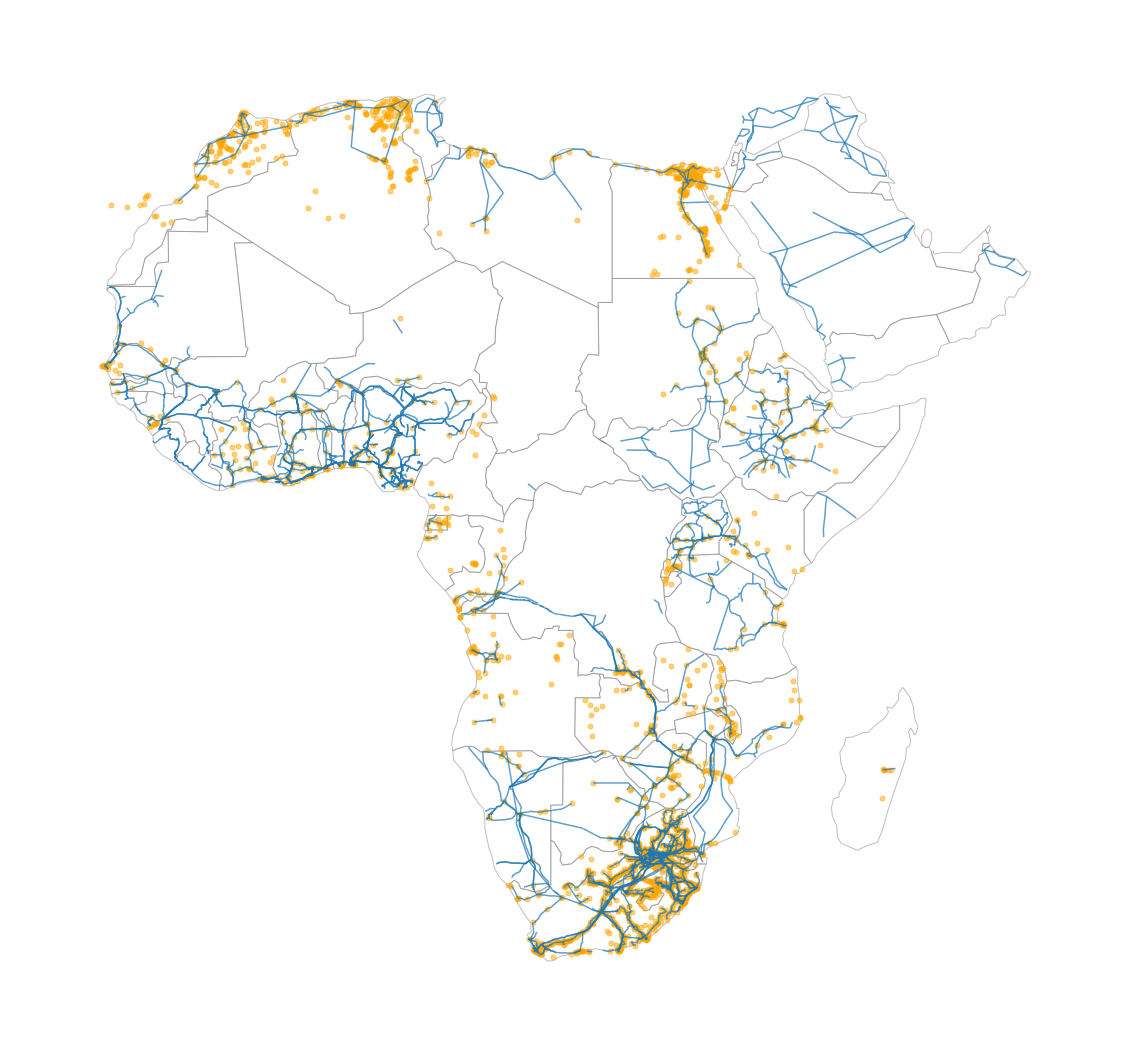

In [64]:
ax = africa_network[africa_network.voltage_kV > 110].plot(figsize=(20, 20),alpha = 0.7)
geoplot.polyplot(africa ,edgecolor='grey', ax=ax, alpha = 0.5)
africa_substations.plot(figsize=(20, 20),markersize=25, color='orange',alpha = 0.5, ax=ax)
plt.savefig('africa_transmission_and substations_110.png')